In [1]:
# Saving and type checking
import shutil
import typing
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import FacetNormal, SpatialCoordinate, variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm

from local_fenics.fenics import *

In [2]:
import gmsh
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
from dolfinx.graph import create_adjacencylist
import dolfinx.io.gmshio

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(
            boundary[0], boundary[1]
            )
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass,
                         [L / 2, H, 0
                          ]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

res_min = r / 3.7
res_max = 1.5 * r
if mesh_comm.rank == model_rank:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8 * r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")
domain, _, ft = io.gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Ellipse)
Info    : Done meshing 1D (Wall 0.0096319s, CPU 0.009625s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Simple recombination completed (Wall 0.0251586s, CPU 0.023824s): 1180 quads, 354 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.773076, min Q = 0.435836
Info    : Done meshing 2D (Wall 0.0717332s, CPU 0.061081s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 50%] Meshing curve 4 order 2
Info    : [ 70%] Meshing curve 5 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 0.845684 (0 elements in ]0, 0.2]); wo

In [3]:
ft
fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker
V = VectorFunctionSpace(domain, ('CG', 2))
Q = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)
dx = ufl.Measure('cell', subdomain_id='everywhere')

create_connectivity(domain=domain)
ds = ufl.Measure("ds", domain=domain)
n = FacetNormal(domain)
u, v = TrialFunction(V), TestFunction(V)
u_, u_n, u_n1, u_s,u_inlet = Function(V), Function(V), Function(V), Function(V),Function(V)
u_.name = 'Velocity'
p, q, = TrialFunction(Q), TestFunction(Q)
p_ = Function(Q)
p_.name = 'Pressure'
phi = Function(Q)

In [4]:
T = 1
Nt = 10
dt = T / Nt
mu = Constant(domain, 0.001)
rho = Constant(domain, 1)
f = Constant(V, (0, 0))

sdim,xdim= get_space_dim(space=V)
class InletVelocity():

    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((sdim, x.shape[1]), dtype=fem.petsc.PETSc.ScalarType)
        values[0] = (-np.abs(self.t - 0.5) + 0.5) *0.01
        values[1] = 0.002
        return values


u_inlet_f = InletVelocity(1)
u_inlet = Function(V)

u_noslip = vector(0, 0)

bcsV = [
    DirichletBC(V, Function(V, u_noslip), (ft, wall_marker)),
    DirichletBC(V, Function(V, u_noslip), (ft, obstacle_marker)),
    DirichletBC(V, u_inlet, (ft, inlet_marker)),
    ]

bcsQ = [
    DirichletBC(Q, Constant(Q, 0), (ft, outlet_marker)),
    ]

F1 = rho / dt * ((u - u_n)|dot|v) * dx
F1 += (
    ((1.5 * (u_n|dot|nabla_grad(u_n))) - 0.5 *
     (u_n1|dot|nabla_grad(u_n1)))|inner|v
    ) * dx
F1 += 0.5 * mu * (grad(u + u_n)|inner|grad(v)) * dx - (p_|dot|div(v)) * dx
F1 += (f|dot|v) * dx

F2 = (grad(p)|dot|grad(q)) * dx
F2 += 1 / dt * (div(u_s)|dot|q) * dx

F3 = (u|dot|v) * dx
F3 += -(u_s|dot|v) * dx + dt * (nabla_grad(phi)|dot|v) * dx

In [5]:
addv, mod = LinearProblem.ghost_updates()
addv = addv.ADD
mod = mod.REVERSE

problem1 = LinearProblem(
    lhs(F1),
    rhs(F1),
    bcsV,
    u=u_s,
    petsc_options={
        'ksp_type': 'bcgs',
        'pc_type': 'lu',
        'pc_factor_mat_ordering_type': 'rcm'
        },
    assemble_options={
        'assemble_A': True, 'assemble_b': False
        },
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )
problem2 = LinearProblem(
    lhs(F2),
    rhs(F2),
    bcsQ,
    u=phi,
    petsc_options={
        'ksp_type': 'minres',
        'pc_type': 'hypre',
        'hypretype': 'boomeramg',
        },
    assemble_options={
        'assemble_A': True, 'assemble_b': False
        },
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )

problem3 = LinearProblem(
    lhs(F3),
    rhs(F3),
    bcs=[],
    u=u_,
    petsc_options={
        'ksp_type': 'cg',
        'pc_type': 'sor',
        },
    assemble_options={
        'assemble_A': True, 'assemble_b': False
        },
    ghost_opions={
        'addv': addv, 'mod': mod
        },
    )

In [6]:
try:
    shutil.rmtree('/home/VTK/2Stokes_Files')
except:
    print('Directory empty yet')

with io.XDMFFile(
    domain.comm, '/home/VTK/2Stokes_Files/stokes.xdmf', 'w'
    ) as file:
    file.write_mesh(domain)
    for time in tqdm(desc='Solving PDE', iterable=np.arange(0, T, dt)):
        u_inlet_f.t = time
        u_inlet.interpolate(u_inlet_f)

        problem1.assemble_b()
        problem1.solve()

        problem2.assemble_b()
        problem2.solve()
        p_.interpolate(Function(Q, phi + p_))

        problem3.assemble_b()
        problem3.solve()

        u_n1.interpolate(u_n)
        u_n.interpolate(u_)

        file.write_function(u_, time)
        file.write_function(p_, time)

Directory empty yet


Solving PDE: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


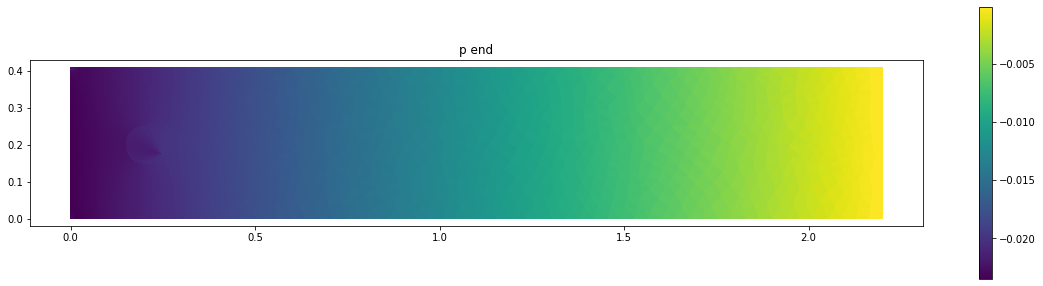

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
PostProcess.graph2D(
    fig=fig,
    lists=[[p_, ax, 'p end']],
    natural_show=True,     # points_on=True,
    )